In [24]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn")
import scipy

from tqdm import tqdm

In [2]:
def compute_pairwise_norm(x,y):
    
    diff = (x[:, None, :] - y[None, :, :])
    
    norm  = np.linalg.norm(diff, axis = -1)
    
    return norm

def gaussian_kernel(matrix_1, matrix_2, l):
    
    diff = compute_pairwise_norm(matrix_1,matrix_2)
    
    return np.exp(-diff**2/(2*l**2))

In [209]:
# Generating a Brownian motion

In [285]:
delta_t = 0.01

T = 1.0

N = int(T/delta_t)

bm = []
x = 0
time = np.linspace(0, T, N)
for i in range(N):
    bm.append(x)
    x += np.sqrt(delta_t)*np.random.normal()
    
bm = np.array(bm)

In [311]:
n_samples = 101

delta_t = 0.01

T = 1.0

N = int(T/delta_t)

bm = []
x = 0
time = np.linspace(0, T, N)

rv = np.random.normal(size = (n_samples, N))

rv.shape

bm = np.cumsum(rv*np.sqrt(delta_t), axis = -1)

bm.shape

(101, 100)

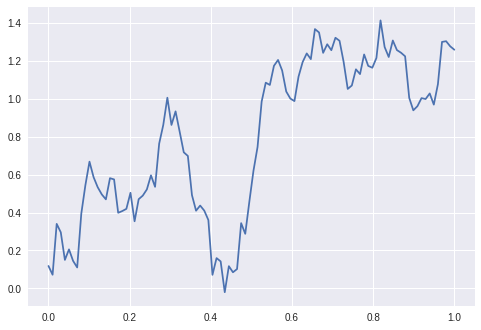

In [314]:
plt.plot(time, bm[0])

In [289]:
l = 0.01
K = gaussian_kernel(time[:, None], time[:, None], l)

I = np.eye(K.shape[0])
nugget = 1e-10
c = scipy.linalg.solve(K + nugget*I, bm)

In [290]:
bm_interp = K@c

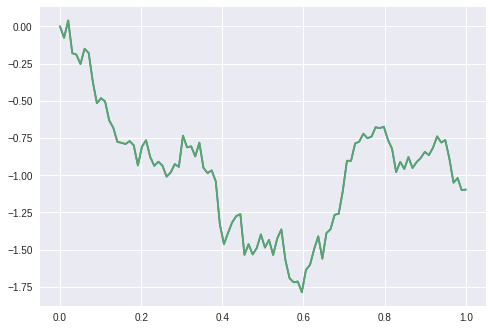

In [291]:
plt.plot(time, bm_interp)
plt.plot(time, bm)

In [292]:
np.linalg.norm(bm_interp-bm)/np.linalg.norm(bm)

5.861266913099285e-11

# Kernel interpolation
We wish to compute 

$$ \int X_sdX_s = \sum_i \sum_j c_i c_j \int_0^T K(t, t_i)dK(t, t_j) = c^\intercal M c$$

where 
$$ M_{i,j} = \int_0^T K(t, t_i)dK(t, t_j)$$

For simplicity

$$ K(t,t_i) = \exp\Big(-\frac{(t-t_i)^2}{2l^2}\Big)$$
and therefore 
$$ dK(t, t_i) = -\frac{(t-t_i)}{l^2}\exp\Big(-\frac{(t-t_i)^2}{2l^2}\Big)$$

In [87]:
from scipy.integrate import quad

from scipy.spatial.distance import pdist

In [67]:
# Generate brownian motion
def generate_bm(delta_t, T, n_samples):
    N = int(T/delta_t)
    bm = []
    x = 0
    time = np.linspace(0, T, N)
    rv = np.random.normal(size = (n_samples, N))

    rv.shape

    bm = np.cumsum(rv*np.sqrt(delta_t), axis = -1)
    
    return bm

delta_t = 0.01
T = 1.0
n_samples = 1000
N = int(T/delta_t)
time = np.linspace(0, T, N)
bm = generate_bm(delta_t, T, n_samples)

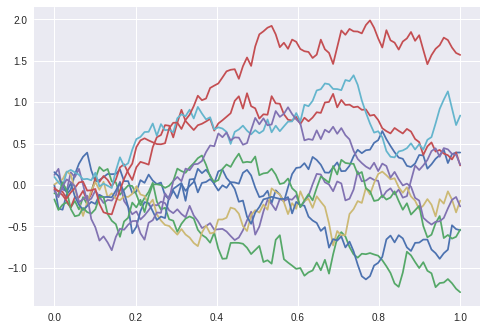

In [68]:
plt.figure()
for i in range(10):
    plt.plot(time, bm[i])

In [150]:
# Compute the M matrix
def compute_M_matrix(N, l):
    M = np.zeros(shape = (N, N))

    for i in range(N):
        for j in range(N):
            t_i = time[i]
            t_j = time[j]
            integrand = lambda t: -(t-t_j)/(l**2)*np.exp(-((t-t_i)**2 + (t-t_j)**2)/(2*l**2))
            M[i,j] = quad(integrand, 0, T)[0]
            
    return M

def compute_interpolant(l, time, Y):
    l = 0.01
    K = gaussian_kernel(time[:, None], time[:, None], l)
    I = np.eye(K.shape[0])
    nugget = 1e-6
    c = scipy.linalg.solve(K + nugget*I, bm.T, assume_a='pos')
    
    return K, c.T

In [151]:
l = 0.1
M = compute_M_matrix(N, l)
K, c = compute_interpolant(l, time, bm)
bm_interp = np.squeeze(K@c[:, :, None], axis = -1)

In [152]:
# Compute the interpolation error
np.mean(np.linalg.norm(bm_interp - bm, axis = -1)/np.linalg.norm(bm, axis = -1))

0.02032670059626981

In [153]:
integral = np.sum(c*np.squeeze(M@c[:, :, None], axis = -1), axis = -1)

print(np.mean(np.linalg.norm(integral - bm[:, -1]**2/2)/np.linalg.norm(bm[:, -1]**2/2)))

31.46423108413791


In [154]:
delta_list = np.linspace(0.005, 0.1, 10)[::-1]

interpolation_error = []
integral_error = []
integral_error_ito = []

kernel_integral = []

l = 0.001
for i in tqdm(range(len(delta_list))):
    delta_t = delta_list[i]
    T = 1.0
    n_samples = 1000
    N = int(T/delta_t)
    
    # Generate the BM
    bm = generate_bm(delta_t, T, n_samples)
    time = np.linspace(0, T, N)
    
    # Compute the M matrix
    M = compute_M_matrix(N,l )
    
    # Compute the interpolant
    K, c = compute_interpolant(l, time, bm)
    bm_interp = np.squeeze(K@c[:, :, None], axis = -1)

    
    # Compute the interpolation error
    i_error = np.mean(np.linalg.norm(bm_interp - bm, axis = -1)/np.linalg.norm(bm, axis = -1))
    interpolation_error.append(i_error)
    
    # Compute the integral
    integral = np.sum(c*np.squeeze(M@c[:, :, None], axis = -1), axis = -1)
    
    kernel_integral.append(integral)
    
    # Compute the integral error 
    int_error = np.mean(np.linalg.norm(integral - bm[:, -1]**2/2)/np.linalg.norm(bm[:, -1]**2/2))
    integral_error.append(int_error)
    
    # Compute the integral error with ito
    int_ito = np.mean(np.linalg.norm(integral - bm[:, -1]**2/2 - 0.5*T)/np.linalg.norm(bm[:, -1]**2/2 - 0.5*T))
    integral_error_ito.append(int_ito)
    
kernel_integral = np.array(kernel_integral)

100%|██████████| 10/10 [00:02<00:00,  3.99it/s]


In [163]:
np.min(integral_error)

0.03872638625234738

In [155]:
delta_list

array([0.1       , 0.08944444, 0.07888889, 0.06833333, 0.05777778,
       0.04722222, 0.03666667, 0.02611111, 0.01555556, 0.005     ])

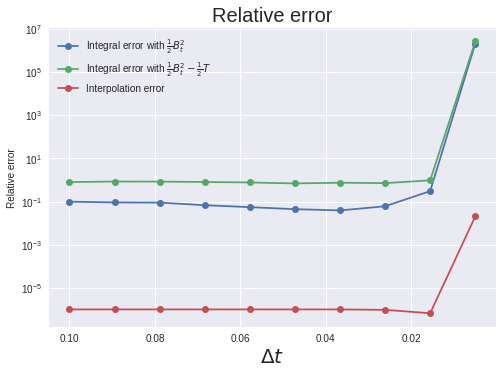

In [156]:
plt.figure()
plt.plot(delta_list, integral_error, marker='o', label = r'Integral error with $\frac{1}{2}B_t^2$')
plt.plot(delta_list, integral_error_ito, marker='o', label = r'Integral error with $\frac{1}{2}B_t^2 - \frac{1}{2}T$')
plt.plot(delta_list,interpolation_error, marker='o',label='Interpolation error')
plt.yscale('log')
plt.xlabel(r'$\Delta t$', size = 20)
plt.ylabel("Relative error", size= 10)
plt.title(r"Relative error", size = 20)
plt.gca().invert_xaxis()
plt.legend()
plt.show()

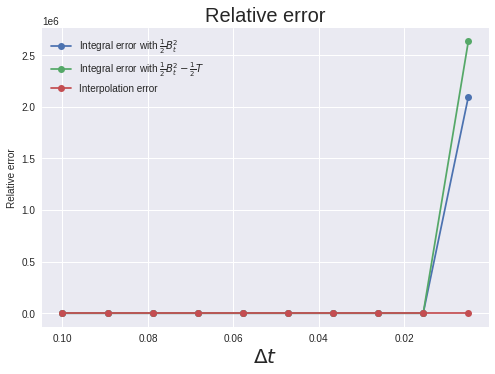

In [157]:
plt.figure()
plt.plot(delta_list, integral_error, marker='o', label = r'Integral error with $\frac{1}{2}B_t^2$')
plt.plot(delta_list, integral_error_ito, marker='o', label = r'Integral error with $\frac{1}{2}B_t^2 - \frac{1}{2}T$')
plt.plot(delta_list,interpolation_error, marker='o',label='Interpolation error')
plt.gca().invert_xaxis()
plt.xlabel(r'$\Delta t$', size = 20)
plt.ylabel("Relative error", size= 10)
plt.title(r"Relative error", size = 20)
plt.legend()
plt.show()

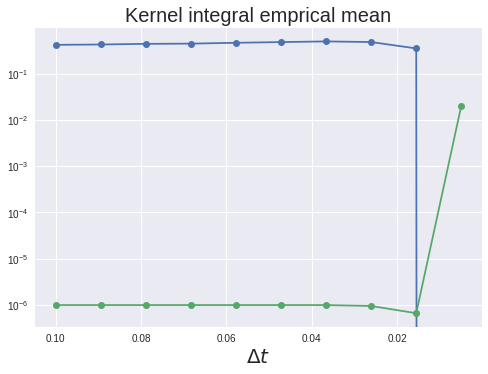

In [161]:
plt.figure()
plt.plot(delta_list, np.mean(kernel_integral, axis  = -1), marker='o')
plt.title("Kernel integral emprical mean", size = 20)
plt.plot(delta_list,interpolation_error, marker='o',label='Interpolation error')
plt.xlabel(r'$\Delta t$', size = 20)
plt.gca().invert_xaxis()
plt.yscale('log')
plt.show()